# 데이터 로드 및 전처리

### 1. 라이브러리 로드

In [4]:
%pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!sudo apt-get install -y fonts-nanum
%pip install lightgbm

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

Note: you may need to restart the kernel to use updated packages.
/bin/bash: sudo: command not found
Note: you may need to restart the kernel to use updated packages.


### 2. 데이터 로드

In [5]:
train_path = "/home/upstage-ml-regression-ml_2/data/external/train.csv"
test_path = "/home/upstage-ml-regression-ml_2/data/external/test.csv"
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [6]:
# 데이터 shape 확인
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [7]:
display(dt.loc[[1]].T)
# display(dt_test.loc[[1]].T)

,1
시군구,서울특별시 강남구 개포동
번지,658-1
본번,658.0
부번,1.0
아파트명,개포6차우성
전용면적(㎡),79.97
계약년월,201712
계약일,22
층,4
건축년도,1987


### 3. 결측치 및 이상치 처리

In [8]:
# train과 test 구분을 위한 컬럼을 만들어주고 하나의 데이터로 합쳐줌
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 

concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [9]:
# 어려운 컬럼 이름 바꿔줌
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [10]:

# 집값과 전혀 상관 없을 것 같은 아래 변수들은 과감히 지워줌
#
# 해제사유발생일
# 등기신청일자
# 거래유형
# 중개사소재지
# k-전화번호
# k-팩스번호
# 단지소개기존clob
# k-홈페이지
# k-등록일자
# k-수정일자
# 고용보험관리번호
# 단지승인일
# 관리비 업로드
# 단지신청일

concat.drop(columns=["해제사유발생일",
                    "등기신청일자",
                    "거래유형",
                    "중개사소재지",
                    "k-전화번호",
                    "k-팩스번호",
                    "단지소개기존clob",
                    "k-홈페이지",
                    "k-등록일자",
                    "k-수정일자",
                    "고용보험관리번호",
                    "단지승인일",
                    "관리비 업로드",
                    "단지신청일"], inplace=True)

In [11]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '사용허가여부',
       '좌표X', '좌표Y', 'target', 'is_test'],
      dtype='object')

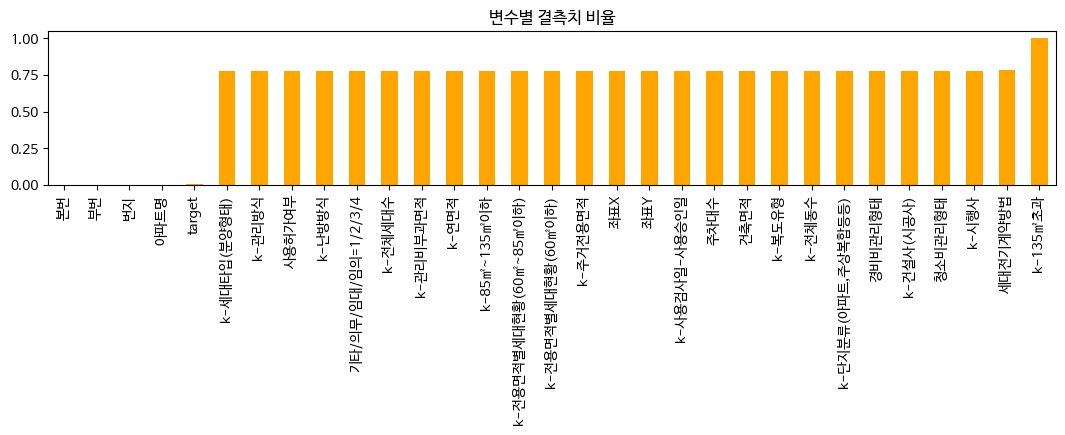

In [12]:
# 결측치 비율 확인
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [13]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
k-단지분류(아파트,주상복합등등)         877273
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-전용면적별세대현황(60㎡이하)         876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-85㎡~135㎡이하               876170
k-135㎡초과                  1127765
경비비관리형태                    877561
세대전기계약방법      

In [14]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 39 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-세대타입(분양형태)            251969 non-null   object 
 13  k-관리방식                  251969 non-null   object 
 14  k-복도유

In [15]:
# 본번, 부번 str 형태로 수정
concat_select = concat
concat['본번'] = concat['본번'].astype('str')
concat['부번'] = concat['부번'].astype('str')

In [16]:
# 그래도 변수가 너무 많은 것 같음. 좀 더 과감하게 지워버려야겠음
concat_select.drop(columns=['좌표X', 
                    '좌표Y',
                    'k-사용검사일-사용승인일',
                    '사용허가여부'], inplace=True)

In [17]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 35 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128094 non-null  object 
 3   부번                      1128094 non-null  object 
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-세대타입(분양형태)            251969 non-null   object 
 13  k-관리방식                  251969 non-null   object 
 14  k-복도유

In [18]:
# 연속형 변수와 범주형 변수 분리
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4']


#### 3.1 결측치 처리

In [19]:
# 범주형 변수는 null을 채워서 보간해줌
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

In [20]:
# 연속형 변수는 어떻게 보간할까...
# 단지 키(시군구+도로명+아파트명+건축년도)를 만들고 같은 단지 내 관측들에서 median 값으로 채우자
concat_select["complex_key"] = (
    concat_select["시군구"].astype(str).str.strip() + "|" +
    concat_select["도로명"].astype(str).str.strip() + "|" +
    concat_select["아파트명"].astype(str).str.strip() + "|" +
    concat_select["건축년도"].astype(str).str.strip()
)

concat_select[continuous_columns].isna().mean().sort_values(ascending=False)

k-135㎡초과                  0.999708
k-전체동수                    0.777601
건축면적                      0.776778
주차대수                      0.776777
k-85㎡~135㎡이하              0.776682
k-주거전용면적                  0.776682
k-전용면적별세대현황(60㎡이하)        0.776682
k-전용면적별세대현황(60㎡~85㎡이하)    0.776682
k-관리비부과면적                 0.776642
k-전체세대수                   0.776642
k-연면적                     0.776642
target                    0.008219
전용면적                      0.000000
계약년월                      0.000000
건축년도                      0.000000
층                         0.000000
계약일                       0.000000
is_test                   0.000000
dtype: float64

In [21]:

def _fill_by_group_median(df, col, group_cols):
    # group_cols 순서대로 내려가며 채우기
    s = df[col]
    for gcols in group_cols:
        med = df.groupby(gcols)[col].transform("median")
        s = s.fillna(med)
    return s

group_levels = [
    ["complex_key"],                # 같은 단지
    ["시군구","아파트명"],             # 같은 시군구의 같은 아파트명
    ["시군구"],                      # 같은 시군구
]

for col in continuous_columns:
    if col not in concat_select.columns: 
        continue
    was_na = concat_select[col].isna()
    concat_select[col] = _fill_by_group_median(concat_select, col, group_levels)
    # 전역 중앙값으로 최종 백업
    concat_select[col] = concat_select[col].fillna(concat_select[col].median())
    

In [22]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 36 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1128094 non-null  object 
 2   본번                      1128094 non-null  object 
 3   부번                      1128094 non-null  object 
 4   아파트명                    1128094 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      1128094 non-null  object 
 12  k-세대타입(분양형태)            1128094 non-null  object 
 13  k-관리방식                  1128094 non-null  object 
 14  k-복도유

In [23]:
concat_select.isnull().sum()         

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-135㎡초과                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
target                    0
is_test                   0
complex_key         

In [24]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,k-135㎡초과,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,target,is_test,complex_key
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,70.0,직영,단일계약,직영,4858.0,262.0,임의,124000.0,0,서울특별시 강남구 개포동|언주로 3|개포6차우성|1987


#### 3.2 이상치 처리

In [25]:
concat_select.shape

(1128094, 36)

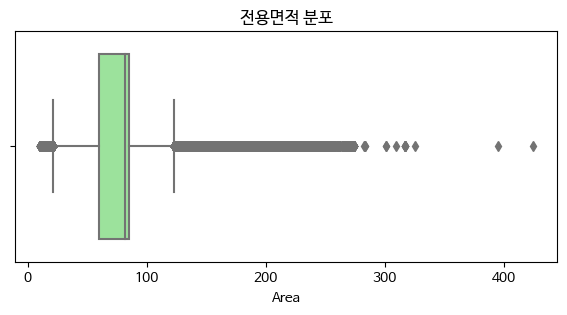

In [26]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [27]:
# 이상치 일부러 제거 안 함. 넓은 평수도 있을 수 있으므로

In [28]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

# - 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
# - 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam
concat_select.columns

# - 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
# - 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.
concat_select.shape

(1128094, 40)

In [30]:
# 금리 데이터 로드
rate_df = pd.read_csv("/home/upstage-ml-regression-ml_2/data/processed/interest_rate.csv")

# 연월을 datetime으로 변환
rate_df['연월'] = pd.to_datetime(rate_df['연월'], format="%Y/%m")
rate_df['금리'] = rate_df['금리'].astype(float)

# 연도와 월 분리
rate_df['계약년'] = rate_df['연월'].dt.year
rate_df['계약월'] = rate_df['연월'].dt.month

print(rate_df.head())

# 데이터 타입 확인
print("concat_select 타입:")
print(concat_select[['계약년','계약월']].dtypes)
print("rate_df 타입:")
print(rate_df[['계약년','계약월']].dtypes)

# 데이터 타입 통일 (둘 다 정수형으로 변환)
concat_select['계약년'] = pd.to_numeric(concat_select['계약년'], errors='coerce')
concat_select['계약월'] = pd.to_numeric(concat_select['계약월'], errors='coerce')

          연월   금리   계약년  계약월
0 2007-01-01  4.5  2007    1
1 2007-02-01  4.5  2007    2
2 2007-03-01  4.5  2007    3
3 2007-04-01  4.5  2007    4
4 2007-05-01  4.5  2007    5
concat_select 타입:
계약년    object
계약월    object
dtype: object
rate_df 타입:
계약년    int64
계약월    int64
dtype: object


In [31]:
# 병합
concat_select = pd.merge(
    concat_select,
    rate_df[['계약년','계약월','금리']],
    on=['계약년','계약월'],
    how='left'
)

# 확인
print(concat_select[['계약년','계약월','금리']].head())


    계약년  계약월   금리
0  2017   12  1.5
1  2017   12  1.5
2  2017   12  1.5
3  2018    1  1.5
4  2018    1  1.5


In [32]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,target,is_test,complex_key,구,동,계약년,계약월,강남여부,신축여부,금리
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,124000.0,0,서울특별시 강남구 개포동|언주로 3|개포6차우성|1987,강남구,개포동,2017,12,1,0,1.5


In [33]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)
dt_test.head(1)
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()
    
    # 훈련 데이터와 테스트 데이터의 모든 고유값을 합쳐서 fit
    all_values = pd.concat([dt_train[col], dt_test[col]]).astype(str).unique()
    lbl.fit(all_values)
    
    # 변환 적용
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    dt_test[col] = lbl.transform(dt_test[col].astype(str))
    
    # 레이블 인코더 저장
    label_encoders[col] = lbl

print("레이블 인코딩 완료!")



(1118822, 40) (9272, 40)
연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', 'target', '계약년', '계약월', '강남여부', '신축여부', '금리']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'complex_key', '구', '동']


100%|██████████| 19/19 [00:05<00:00,  3.53it/s]

레이블 인코딩 완료!


In [34]:
# data shape 맞는지 검증
assert dt_train.shape[1] == dt_test.shape[1] 

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [35]:
import re
import pandas as pd

def make_safe_columns(df: pd.DataFrame):
    # 1) 특수문자 -> '_' 치환
    safe = [re.sub(r'[^\w]+', '_', str(c)).strip('_') for c in df.columns]
    # 2) 빈 이름/중복 처리
    seen = {}
    new_cols = []
    for s in safe:
        if s == '':
            s = 'col'
        if s in seen:
            seen[s] += 1
            s = f"{s}_{seen[s]}"
        else:
            seen[s] = 0
        new_cols.append(s)
    mapping = dict(zip(df.columns, new_cols))
    return df.rename(columns=mapping), mapping

# 전처리 끝난 데이터프레임들에 적용
X_train, map_tr = make_safe_columns(X_train)
X_val   = X_val.rename(columns=map_tr)
# (있다면) X_test도 동일 매핑 적용
# X_test  = X_test.rename(columns=map_tr)


In [36]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

params = dict(
    objective="regression",
    metric="rmse",
    boosting_type="gbdt",
    learning_rate=0.03,
    num_leaves=63,
    min_data_in_leaf=30,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=1.0,
    n_estimators=10000,
    random_state=42,
    verbosity=-1,
)

model = lgb.LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)],
)

pred_val = model.predict(X_val)
rmse = mean_squared_error(y_val, pred_val, squared=False)
print(f"Valid RMSE: {rmse:.6f}")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 15687.2
[200]	valid_0's rmse: 12096.7
[300]	valid_0's rmse: 10702.3
[400]	valid_0's rmse: 9914.66
[500]	valid_0's rmse: 9379.59
[600]	valid_0's rmse: 8983.26
[700]	valid_0's rmse: 8676.69
[800]	valid_0's rmse: 8415.61
[900]	valid_0's rmse: 8210.9
[1000]	valid_0's rmse: 8020.29
[1100]	valid_0's rmse: 7873.78
[1200]	valid_0's rmse: 7737.45
[1300]	valid_0's rmse: 7623.9
[1400]	valid_0's rmse: 7516.23
[1500]	valid_0's rmse: 7421.11
[1600]	valid_0's rmse: 7338.83
[1700]	valid_0's rmse: 7263.36
[1800]	valid_0's rmse: 7187.58
[1900]	valid_0's rmse: 7120.83
[2000]	valid_0's rmse: 7063.98
[2100]	valid_0's rmse: 7010.74
[2200]	valid_0's rmse: 6951.47
[2300]	valid_0's rmse: 6898.42
[2400]	valid_0's rmse: 6854.57
[2500]	valid_0's rmse: 6813.55
[2600]	valid_0's rmse: 6776.24
[2700]	valid_0's rmse: 6745.91
[2800]	valid_0's rmse: 6712.26
[2900]	valid_0's rmse: 6680.28
[3000]	valid_0's rmse: 6649.28
[3100]	valid_0's rm

In [37]:
with open('lightgbm_main.pkl', 'wb') as f:
    pickle.dump(model, f)

In [38]:
pred_val

array([32668.17198956, 53136.1015009 , 43202.22327022, ...,
       25596.87198678, 24472.99030294, 86259.04285342])

In [39]:
preds_df = pd.DataFrame(pred_val.astype(int), columns=["target"])
preds_df.to_csv('/home/upstage-ml-regression-ml_2/outputs/add_interest_rate.csv', index=False)